In [1]:
# SE22MAID002
# PARAM SHIV ASHISH
# MTECH AI AND DS

# IMPORTING REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score,RepeatedKFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,RobustScaler

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.m_estimate import MEstimateEncoder
warnings.filterwarnings('ignore')

In [2]:
#LOADING DATA INTO PANDAS DATAFRAME
trainDF = pd.read_csv("C:\\Users\\param\\Downloads\\input\\Traindata.csv")
testDF = pd.read_csv("C:\\Users\\param\\Downloads\\input\\DataSetRetail.csv")
submissionDF = pd.read_csv("C:\\Users\\param\\Downloads\\input\\submission_format.csv")

In [3]:
trainDF.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17-01-2011,8091,216418,99.0375,111.8625,0,0,20
1,2,17-01-2011,8091,216419,99.0375,99.0375,0,0,28
2,3,17-01-2011,8091,216425,133.9500,133.9500,0,0,19
3,4,17-01-2011,8091,216233,133.9500,133.9500,0,0,44
4,5,17-01-2011,8091,217390,141.0750,141.0750,0,0,52


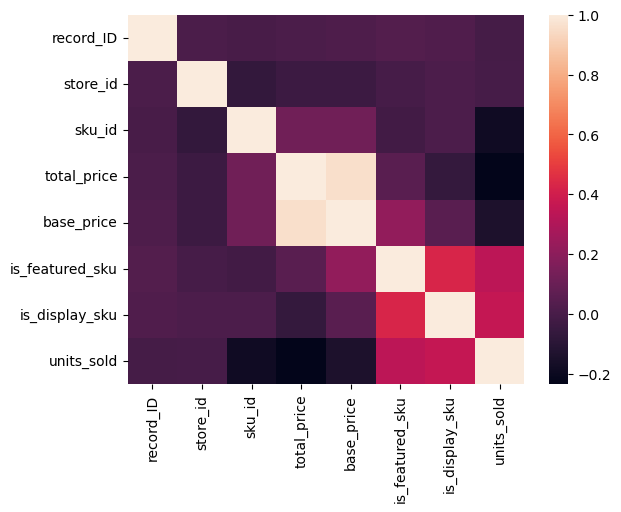

In [4]:
import seaborn as sns 
#plotting the heatmap for correlation
ax = sns.heatmap(trainDF.corr())

In [5]:
testDF.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16-07-2013,8091,216418,108.3000,108.3000,0,0
1,212646,16-07-2013,8091,216419,109.0125,109.0125,0,0
2,212647,16-07-2013,8091,216425,133.9500,133.9500,0,0
3,212648,16-07-2013,8091,216233,133.9500,133.9500,0,0
4,212649,16-07-2013,8091,217390,176.7000,176.7000,0,0


In [6]:
#SAMPLE SUBMISSION DATAFRAME
submissionDF.head()

,record_ID,units_sold
0,212645,0
1,212646,0
2,212647,0
3,212648,0
4,212649,0


In [7]:
# FOR MORE TRAINING DATAFRAME INSIGHTS
trainDF.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [8]:
#INSERING RELAVENT TOTAL PRICE VALUES WHERE THEY ARE MISSING
trainDF.total_price=trainDF.total_price.fillna(469.5375)

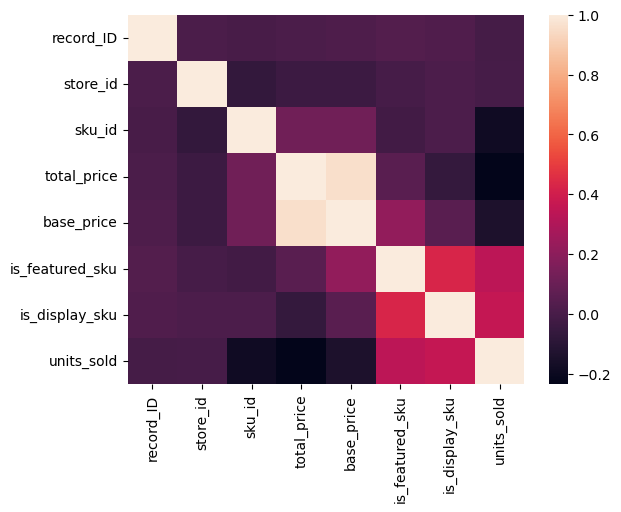

In [9]:
import seaborn as sns 
#plotting the heatmap for correlation
ax = sns.heatmap(trainDF.corr())

In [10]:
#CREATING NEW FEATURES

def countID(train,test,col,name):
    temp=train.groupby(col)['record_ID'].count().reset_index().rename(columns={'record_ID':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name]=train[name].astype(float)
    test[name]=test[name].astype(float)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def G_A_U(train,test,col,name):
    temp=train.groupby(col)['units_sold'].mean().reset_index().rename(columns={'units_sold':name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

def G_A_P(train,test,col,price='base_price',name='name'):
    temp=train.groupby(col)[price].mean().reset_index().rename(columns={price:name})
    train=pd.merge(train,temp,how='left',on=col)
    test=pd.merge(test,temp,how='left',on=col)
    train[name].fillna(np.median(temp[name]),inplace=True)
    test[name].fillna(np.median(temp[name]),inplace=True)
    return train,test

In [11]:
#Genearting count of records per 'sku-id & store-id' 
trainDF,testDF = countID(trainDF,testDF,col=['sku_id','store_id'],name='count_id_sku_store')
#Genearting count of records per 'sku-id'
trainDF,testDF = countID(trainDF,testDF,col=['sku_id'],name='count_id_sku') 
#Genearting count of records per 'store-id'
trainDF,testDF = countID(trainDF,testDF,col=['store_id'],name='count_id_store') 

#Genearting average units sold per 'sku-id & store-id'
trainDF,testDF = G_A_U(trainDF,testDF,col=['sku_id','store_id'],name='count_sku_store_id') 
#Genearting average units sold per 'store-id'
trainDF,testDF = G_A_U(trainDF,testDF,col=['store_id'],name='count_store_id') 
#Genearting average units sold per 'sku-id'
trainDF,testDF = G_A_U(trainDF,testDF,col=['sku_id'],name='count_sku_id') 

#Genearting average base price per 'sku-id & store-id'
trainDF,testDF = G_A_P(trainDF,testDF,col=['sku_id','store_id'],price='base_price',name='price_sku_store')
 #Genearting average total price per 'sku-id & store-id'
trainDF,testDF = G_A_P(trainDF,testDF,col=['sku_id','store_id'],price='total_price',name='price_to_sku_store')
#Genearting average base price per 'store-id'
trainDF,testDF = G_A_P(trainDF,testDF,col=['store_id'],price='base_price',name='price_store_id') 
#Genearting average base price per 'sku-id'
trainDF,testDF = G_A_P(trainDF,testDF,col=['sku_id'],price='base_price',name='price_sku_id') 
#Genearting average total price per 'store-id'
trainDF,testDF = G_A_P(trainDF,testDF,col=['store_id'],price='total_price',name='price_to_store_id')
#Genearting average total price per 'sku-id'
trainDF,testDF = G_A_P(trainDF,testDF,col=['sku_id'],price='total_price',name='price_to_sku_id') 

In [12]:
#Converting week feature
le = OrdinalEncoder()
trainDF['week_1']=le.fit_transform(trainDF['week'])
le = OrdinalEncoder()
testDF['week_1']=le.fit_transform(testDF['week'])+130

#Creating week number feature
trainDF['week_num']=trainDF.week_1%52
testDF['week_num']=testDF.week_1%52

trainDF['week_num1']=trainDF.week_1%4
testDF['week_num1']=testDF.week_1%4

# Encoding 'week' it using sine and cosine transform; considering it as a cyclic feature 
trainDF['week_sin'] = np.sin(2 * np.pi * trainDF['week_1'] / 52.143)
trainDF['week_cos'] = np.cos(2 * np.pi * trainDF['week_1'] / 52.143)
testDF['week_sin'] = np.sin(2 * np.pi * testDF['week_1'] / 52.143)
testDF['week_cos'] = np.cos(2 * np.pi * testDF['week_1'] / 52.143)

#Creating feature: percent difference between base price and checkout price.
trainDF['price_diff_percent'] = (trainDF['base_price'] - trainDF['total_price']) / trainDF['base_price']
testDF['price_diff_percent'] = (testDF['base_price'] - testDF['total_price']) / testDF['base_price']

In [13]:
trainDF.tail()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,count_id_sku_store,...,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,week_sin,week_cos,price_diff_percent
150145,212638,09-07-2013,9984,223245,235.8375,235.8375,0,0,38,130.0,...,197.030107,214.878438,186.580537,203.073612,130,26,2,0.043065,-0.999072,0.000000
150146,212639,09-07-2013,9984,223153,235.8375,235.8375,0,0,30,130.0,...,197.030107,220.461485,186.580537,206.303241,130,26,2,0.043065,-0.999072,0.000000
150147,212642,09-07-2013,9984,245338,357.6750,483.7875,1,1,31,130.0,...,197.030107,476.750449,186.580537,432.766248,130,26,2,0.043065,-0.999072,0.260677
150148,212643,09-07-2013,9984,547934,141.7875,191.6625,0,1,12,130.0,...,197.030107,174.616247,186.580537,166.385369,130,26,2,0.043065,-0.999072,0.260223
150149,212644,09-07-2013,9984,679023,234.4125,234.4125,0,0,15,130.0,...,197.030107,209.117532,186.580537,198.309455,130,26,2,0.043065,-0.999072,0.000000


In [14]:
testDF.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,count_id_sku_store,count_id_sku,...,price_store_id,price_sku_id,price_to_store_id,price_to_sku_id,week_1,week_num,week_num1,week_sin,week_cos,price_diff_percent
0,212645,16-07-2013,8091,216418,108.3000,108.3000,0,0,130.0,8840.0,...,181.312372,94.688268,172.272756,91.982702,131,27,3,-0.077343,-0.997005,0.0
1,212646,16-07-2013,8091,216419,109.0125,109.0125,0,0,130.0,8710.0,...,181.312372,94.908763,172.272756,92.349162,131,27,3,-0.077343,-0.997005,0.0
2,212647,16-07-2013,8091,216425,133.9500,133.9500,0,0,130.0,8580.0,...,181.312372,128.285210,172.272756,125.156355,131,27,3,-0.077343,-0.997005,0.0
3,212648,16-07-2013,8091,216233,133.9500,133.9500,0,0,130.0,9620.0,...,181.312372,128.101871,172.272756,124.942208,131,27,3,-0.077343,-0.997005,0.0
4,212649,16-07-2013,8091,217390,176.7000,176.7000,0,0,130.0,9100.0,...,181.312372,158.990538,172.272756,150.867334,131,27,3,-0.077343,-0.997005,0.0


In [15]:
X = trainDF[list(set(trainDF.columns)-set(['record_ID','units_sold','week']))]
Y = np.log1p(trainDF['units_sold'])
X_test =testDF[list(set(testDF.columns)-set(['record_ID','week']))]

In [16]:
X.dtypes

price_sku_store       float64
store_id                int64
sku_id                  int64
price_to_sku_store    float64
count_id_sku          float64
base_price            float64
week_sin              float64
total_price           float64
price_store_id        float64
price_to_sku_id       float64
is_featured_sku         int64
count_sku_id          float64
count_sku_store_id    float64
count_id_sku_store    float64
price_diff_percent    float64
count_id_store        float64
price_to_store_id     float64
count_store_id        float64
price_sku_id          float64
week_num                int32
week_1                  int32
week_cos              float64
week_num1               int32
is_display_sku          int64
dtype: object

In [17]:
X['sku_id'] = X['sku_id'].astype('category')
X['store_id'] = X['store_id'].astype('category')

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150150 entries, 0 to 150149
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price_sku_store     150150 non-null  float64 
 1   store_id            150150 non-null  category
 2   sku_id              150150 non-null  category
 3   price_to_sku_store  150150 non-null  float64 
 4   count_id_sku        150150 non-null  float64 
 5   base_price          150150 non-null  float64 
 6   week_sin            150150 non-null  float64 
 7   total_price         150150 non-null  float64 
 8   price_store_id      150150 non-null  float64 
 9   price_to_sku_id     150150 non-null  float64 
 10  is_featured_sku     150150 non-null  int64   
 11  count_sku_id        150150 non-null  float64 
 12  count_sku_store_id  150150 non-null  float64 
 13  count_id_sku_store  150150 non-null  float64 
 14  price_diff_percent  150150 non-null  float64 
 15  count_id_store   

In [19]:
category_list=['store_id','sku_id']

In [20]:
encoder_final=MEstimateEncoder()
encoder_final.fit(X[category_list], Y)

cat_enc = encoder_final.transform(X[category_list], Y)
continuous_train = X.drop(columns= category_list)
X = pd.concat([cat_enc,continuous_train],axis=1)

test_enc=encoder_final.transform(X_test[category_list])
continuous_test=X_test.drop(columns= category_list)
X_test=pd.concat([test_enc,continuous_test],axis=1)

In [21]:
X.head()

,store_id,sku_id,price_sku_store,price_to_sku_store,count_id_sku,base_price,week_sin,total_price,price_store_id,price_to_sku_id,...,price_diff_percent,count_id_store,price_to_store_id,count_store_id,price_sku_id,week_num,week_1,week_cos,week_num1,is_display_sku
0,3.250779,4.201821,105.800769,102.117692,8840.0,111.8625,0.120208,99.0375,181.312372,91.982702,...,0.11465,1170.0,172.272756,32.805983,94.688268,1,1,0.992749,1,0
1,3.250779,4.051982,105.839135,102.473942,8710.0,99.0375,0.120208,99.0375,181.312372,92.349162,...,0.00000,1170.0,172.272756,32.805983,94.908763,1,1,0.992749,1,0
2,3.250779,3.303344,131.204135,126.671538,8580.0,133.9500,0.120208,133.9500,181.312372,125.156355,...,0.00000,1170.0,172.272756,32.805983,128.285210,1,1,0.992749,1,0
3,3.250779,3.715659,129.916154,126.167308,9620.0,133.9500,0.120208,133.9500,181.312372,124.942208,...,0.00000,1170.0,172.272756,32.805983,128.101871,1,1,0.992749,1,0
4,3.250779,3.850743,164.439519,152.968269,9100.0,141.0750,0.120208,141.0750,181.312372,150.867334,...,0.00000,1170.0,172.272756,32.805983,158.990538,1,1,0.992749,1,0


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150150 entries, 0 to 150149
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   store_id            150150 non-null  float64
 1   sku_id              150150 non-null  float64
 2   price_sku_store     150150 non-null  float64
 3   price_to_sku_store  150150 non-null  float64
 4   count_id_sku        150150 non-null  float64
 5   base_price          150150 non-null  float64
 6   week_sin            150150 non-null  float64
 7   total_price         150150 non-null  float64
 8   price_store_id      150150 non-null  float64
 9   price_to_sku_id     150150 non-null  float64
 10  is_featured_sku     150150 non-null  int64  
 11  count_sku_id        150150 non-null  float64
 12  count_sku_store_id  150150 non-null  float64
 13  count_id_sku_store  150150 non-null  float64
 14  price_diff_percent  150150 non-null  float64
 15  count_id_store      150150 non-nul

In [23]:
X_test.head()

,store_id,sku_id,price_sku_store,price_to_sku_store,count_id_sku,base_price,week_sin,total_price,price_store_id,price_to_sku_id,...,price_diff_percent,count_id_store,price_to_store_id,count_store_id,price_sku_id,week_num,week_1,week_cos,week_num1,is_display_sku
0,3.250779,4.201821,105.800769,102.117692,8840.0,108.3000,-0.077343,108.3000,181.312372,91.982702,...,0.0,1170.0,172.272756,32.805983,94.688268,27,131,-0.997005,3,0
1,3.250779,4.051982,105.839135,102.473942,8710.0,109.0125,-0.077343,109.0125,181.312372,92.349162,...,0.0,1170.0,172.272756,32.805983,94.908763,27,131,-0.997005,3,0
2,3.250779,3.303344,131.204135,126.671538,8580.0,133.9500,-0.077343,133.9500,181.312372,125.156355,...,0.0,1170.0,172.272756,32.805983,128.285210,27,131,-0.997005,3,0
3,3.250779,3.715659,129.916154,126.167308,9620.0,133.9500,-0.077343,133.9500,181.312372,124.942208,...,0.0,1170.0,172.272756,32.805983,128.101871,27,131,-0.997005,3,0
4,3.250779,3.850743,164.439519,152.968269,9100.0,176.7000,-0.077343,176.7000,181.312372,150.867334,...,0.0,1170.0,172.272756,32.805983,158.990538,27,131,-0.997005,3,0


In [24]:
del X['week_num1']

In [25]:
# SPLITING FOR TRAIN AND VALIDATION SETS
xTrain, xValid, yTrain, yValid = train_test_split(X, Y, test_size = 0.2,random_state=12)

In [26]:
# SE22MAID002
# PARAM SHIV ASHISH
# MTECH AI AND DS

#TRAINING THE MODEL UISING LGBM REGRESSOR
model = lgb.LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.1, max_depth=30,
              min_child_samples=20, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_estimators=100, n_jobs=-1,
              num_leaves=1400, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

model.fit(X,Y)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ov

LGBMRegressor(bagging_fraction=0.8, bagging_frequency=4, feature_fraction=0.5,
              max_depth=30, min_child_weight=30, min_data_in_leaf=70,
              min_split_gain=0.0001, n_jobs=-1, num_leaves=1400, silent=True)

In [27]:
X_test.head()

,store_id,sku_id,price_sku_store,price_to_sku_store,count_id_sku,base_price,week_sin,total_price,price_store_id,price_to_sku_id,...,price_diff_percent,count_id_store,price_to_store_id,count_store_id,price_sku_id,week_num,week_1,week_cos,week_num1,is_display_sku
0,3.250779,4.201821,105.800769,102.117692,8840.0,108.3000,-0.077343,108.3000,181.312372,91.982702,...,0.0,1170.0,172.272756,32.805983,94.688268,27,131,-0.997005,3,0
1,3.250779,4.051982,105.839135,102.473942,8710.0,109.0125,-0.077343,109.0125,181.312372,92.349162,...,0.0,1170.0,172.272756,32.805983,94.908763,27,131,-0.997005,3,0
2,3.250779,3.303344,131.204135,126.671538,8580.0,133.9500,-0.077343,133.9500,181.312372,125.156355,...,0.0,1170.0,172.272756,32.805983,128.285210,27,131,-0.997005,3,0
3,3.250779,3.715659,129.916154,126.167308,9620.0,133.9500,-0.077343,133.9500,181.312372,124.942208,...,0.0,1170.0,172.272756,32.805983,128.101871,27,131,-0.997005,3,0
4,3.250779,3.850743,164.439519,152.968269,9100.0,176.7000,-0.077343,176.7000,181.312372,150.867334,...,0.0,1170.0,172.272756,32.805983,158.990538,27,131,-0.997005,3,0


In [28]:
del X_test['week_num1']

In [29]:
# GETTING PREDICTIONS
pred = model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [30]:

preds=np.round(np.expm1(pred))
submissionDF['units_sold']=preds

In [31]:
submissionDF.head()

,record_ID,units_sold
0,212645,17.0
1,212646,20.0
2,212647,31.0
3,212648,29.0
4,212649,20.0


In [32]:
submissionDF.to_csv('DemandForecastPrediction.csv',index=False)